## **Exercise: Metrics & Hyperparameter Tuning**

**Gunakan dataset 'insurance'**

Carilah model dan hyperparameter terbaik untuk memprediksi biaya asuransi tiap individu berdasarkan karakteristiknya.
1. Lakukan EDA singkat untuk mengeksplorasi dataset terlebih dahulu.
2. Lakukan preprocessing pada features jika dibutuhkan.
3. Lakukan modeling dengan menggunakan lasso regression, knn regressor, dan decision tree regressor.<br>
    Kandidat algoritma:
    - lasso = Lasso 
    - knn = KNeighborsRegressor  
    - tree = DecisionTreeRegressor 
4. Pilih 1 model terbaik berdasarkan hasil cross validasi 3 model di atas.
5. Lakukan prediksi pada test set dari model terpilih (sebelum hyperparameter tuning).
6. Lakukan hyperparameter tuning pada model terpilih tsb.
7. Lakukan prediksi pada test set dari model dengan hyperparameter tuning.
8. Bandingkan hasil performa model sebelum dan sesudah tuning.

*Tips: Gunakan Pipeline*

**Features Description**

- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: Smoking
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: Individual medical costs billed by health insurance

## **Import libraries**

In [1]:
# !pip install category_encoders

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
# warnings.filterwarnings('ignore')

## **Load dataset**

In [3]:
df = pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# check missing values
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
df.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


## **Simple EDA**

In [7]:
cat_features = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
cat_features

['sex', 'smoker', 'region']

In [8]:
num_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['charges']))]
num_features

['age', 'bmi', 'children']

In [9]:
# category pada categorical features
for i in cat_features:
    print(f'Total unique values in {i}: ', df[i].nunique())
    print(f'Unique values: ', df[i].unique())
    print()

Total unique values in sex:  2
Unique values:  ['female' 'male']

Total unique values in smoker:  2
Unique values:  ['yes' 'no']

Total unique values in region:  4
Unique values:  ['southwest' 'southeast' 'northwest' 'northeast']



<Axes: xlabel='charges'>

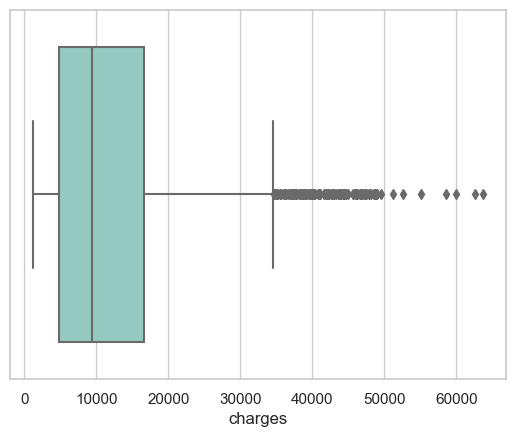

In [10]:
sns.set(style='whitegrid', palette='Set3')
sns.boxplot(x='charges', data=df)

### Outliers

Bisa pertimbangkan untuk drop outliers 

In [11]:
df.shape

(1338, 7)

In [12]:
df = df[df['charges']<50000]
df.shape 

(1331, 7)

### **Plot of categorical features**

In [13]:
sns.set(style='whitegrid', palette='bright')

/var/folders/61/4hf9f1wj7h9d4m5l7_6kdd3w0000gn/T/ipykernel_9364/785621976.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 0)` for the same effect.

  sns.barplot(x = 'charges', y = feature, data = df, ci=0, estimator=np.median)
/var/folders/61/4hf9f1wj7h9d4m5l7_6kdd3w0000gn/T/ipykernel_9364/785621976.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 0)` for the same effect.

  sns.barplot(x = 'charges', y = feature, data = df, ci=0, estimator=np.median)
/var/folders/61/4hf9f1wj7h9d4m5l7_6kdd3w0000gn/T/ipykernel_9364/785621976.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 0)` for the same effect.

  sns.barplot(x = 'charges', y = feature, data = df, ci=0, estimator=np.median)


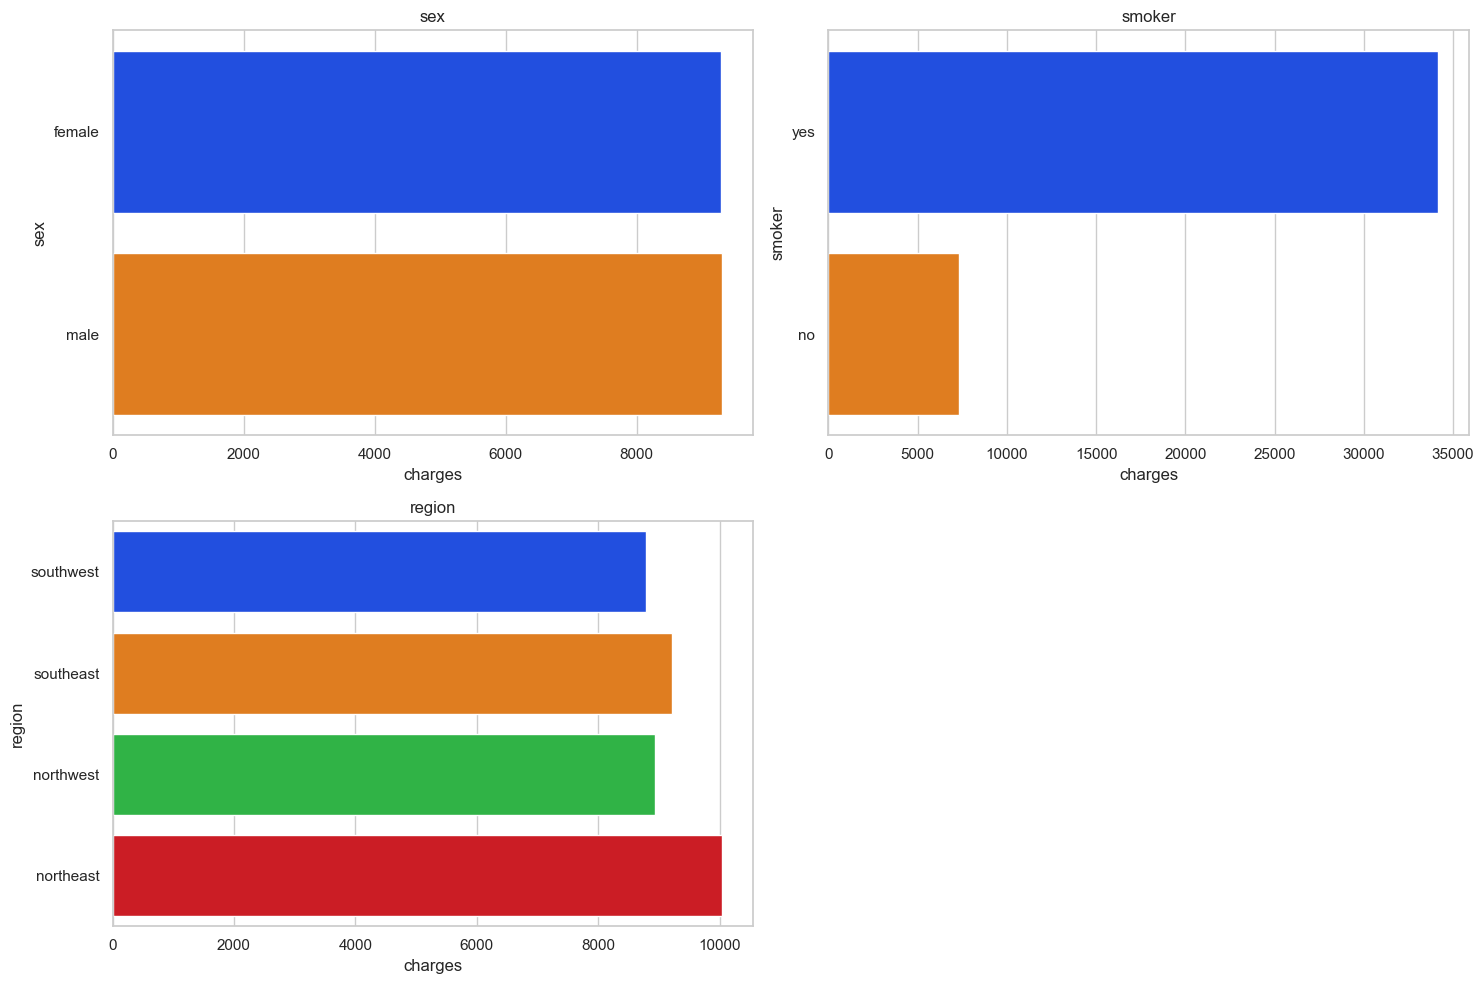

In [14]:
plt.figure(figsize=(15, 10), facecolor='white')
plotnumber = 1

for feature in cat_features:
    ax = plt.subplot(2, 2, plotnumber)
    sns.barplot(x = 'charges', y = feature, data = df, ci=0, estimator=np.median)
    plt.xlabel('charges')
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout();

/var/folders/61/4hf9f1wj7h9d4m5l7_6kdd3w0000gn/T/ipykernel_9364/2847120315.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 0)` for the same effect.

  sns.barplot(data=df, x='sex', y='charges', hue='smoker', estimator=np.median, ci=0);


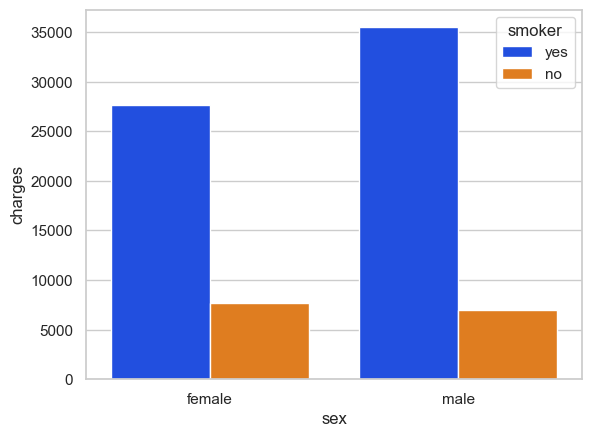

In [15]:
sns.barplot(data=df, x='sex', y='charges', hue='smoker', estimator=np.median, ci=0);

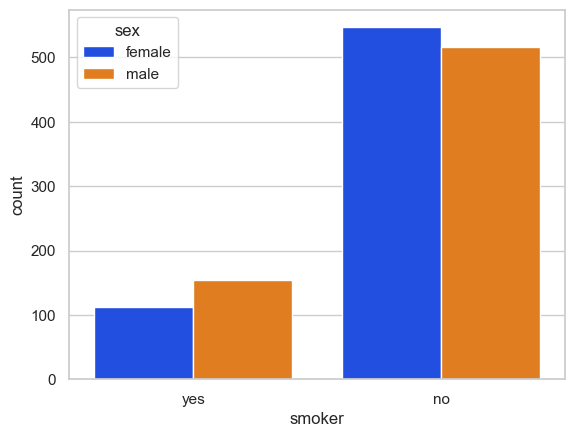

In [16]:
sns.countplot(data=df, x='smoker', hue='sex');

### **Plot of numerical features**

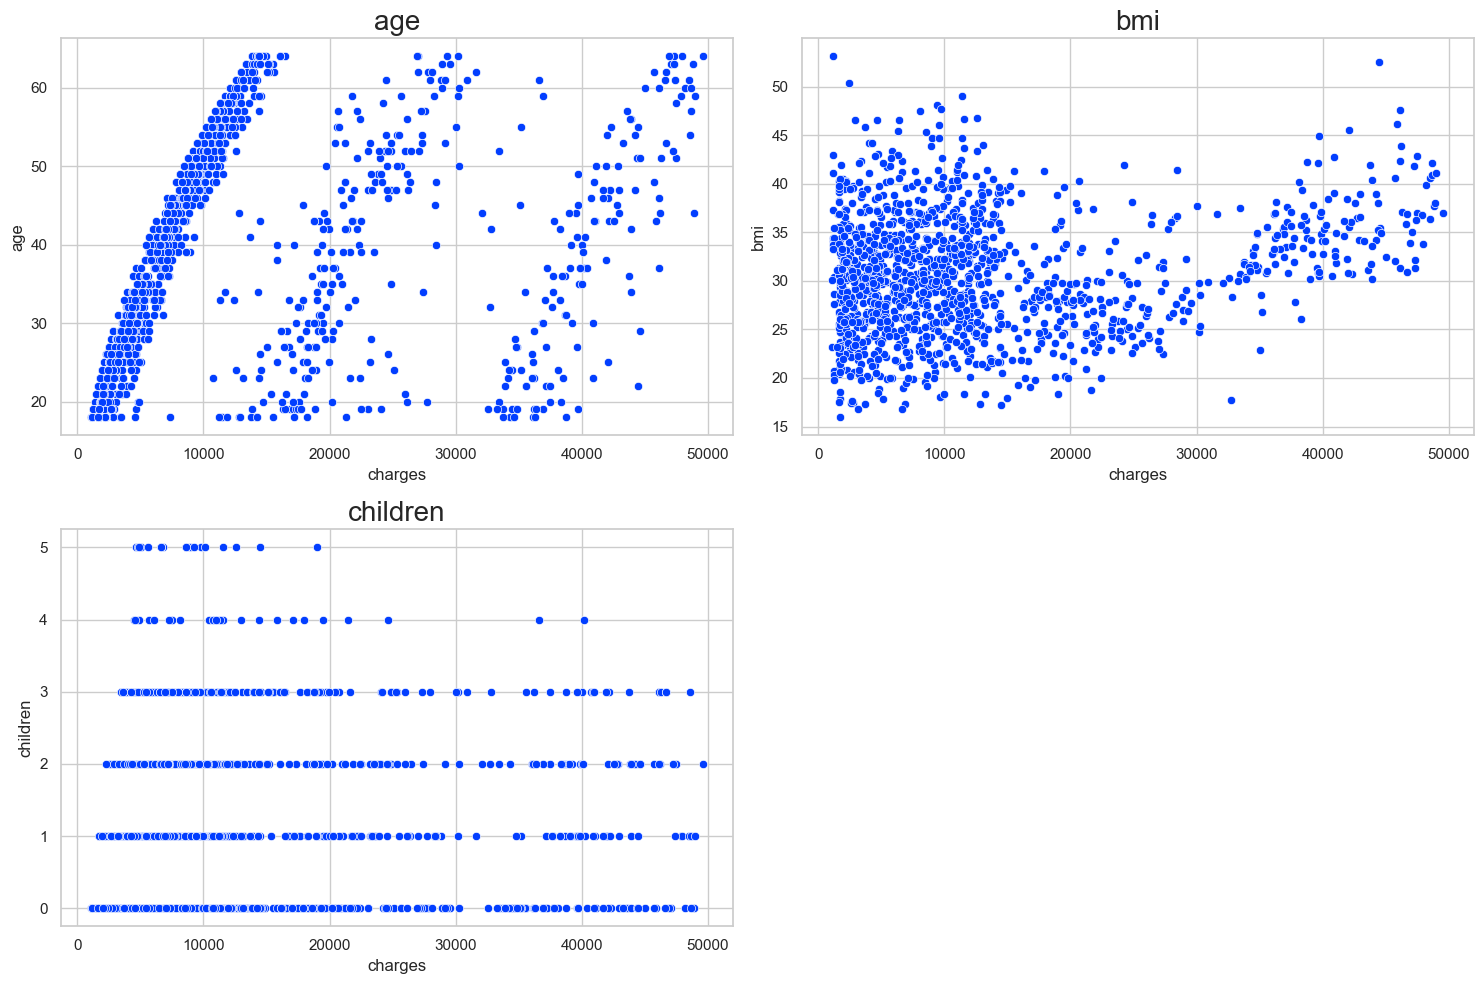

In [17]:
plt.figure(figsize=(15, 10), facecolor='white')
plotnumber = 1

for feature in num_features:

    ax = plt.subplot(2, 2, plotnumber)
    sns.scatterplot(x = 'charges', y = feature, data = df)
    plt.xlabel('charges')
    plt.title(feature, fontsize=20)
    plt.tight_layout();

    plotnumber += 1

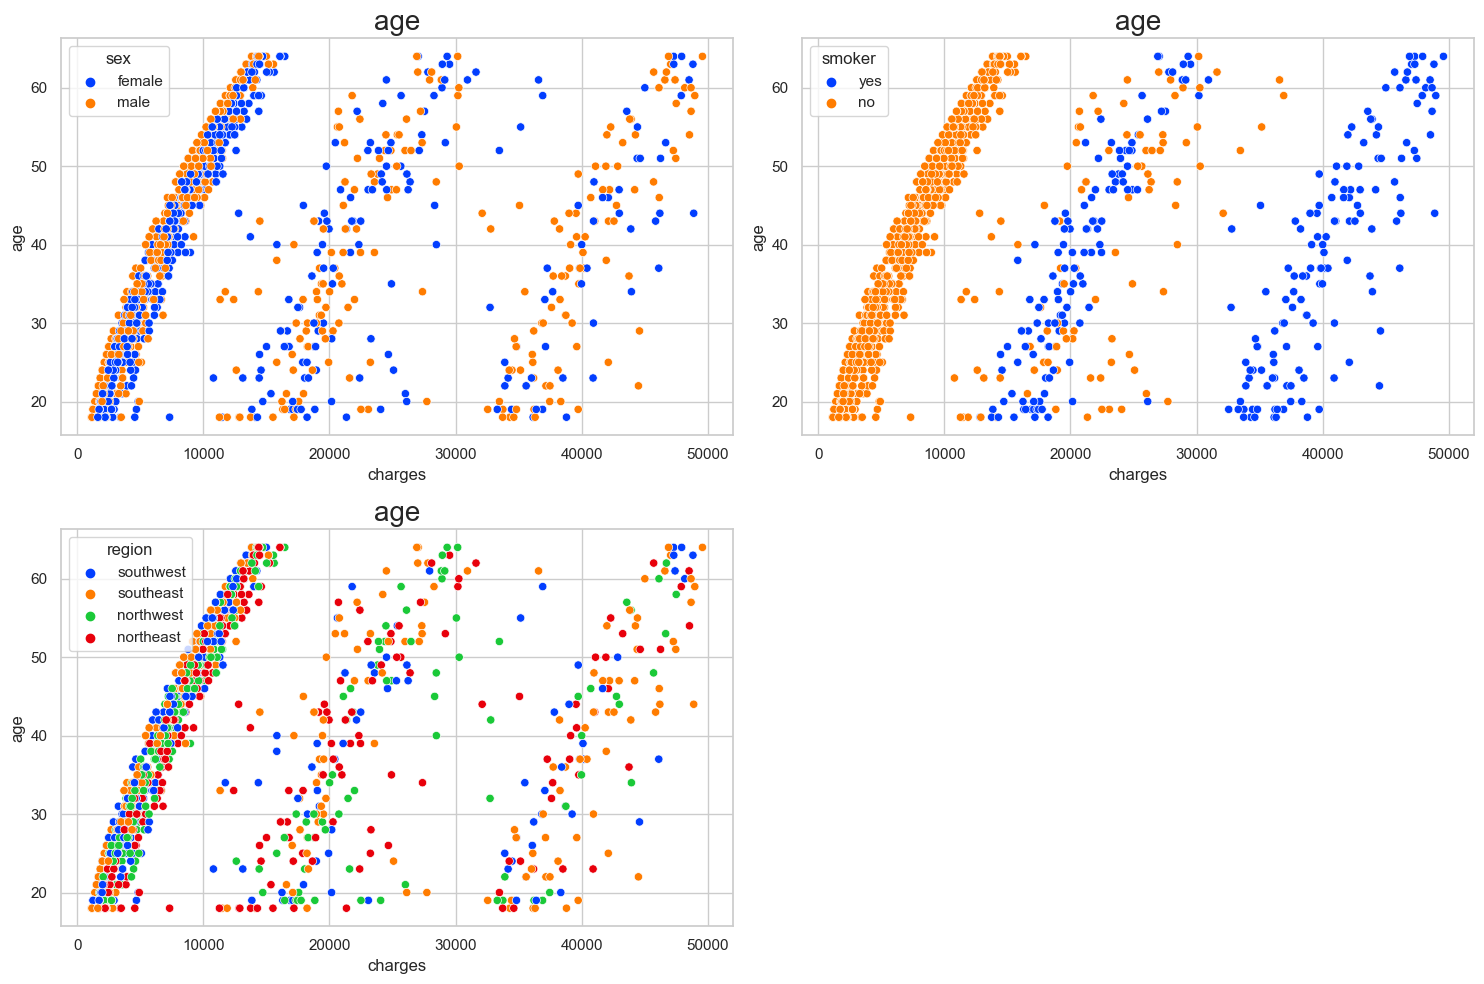

In [18]:
plt.figure(figsize=(15, 10), facecolor='white')
plotnumber = 1

for feature in cat_features:

    ax = plt.subplot(2, 2, plotnumber)
    sns.scatterplot(x = 'charges', y = 'age', hue=feature, data = df)
    plt.xlabel('charges')
    plt.title('age', fontsize=20)
    plt.tight_layout();

    plotnumber += 1

In [19]:
df.shape

(1331, 7)

In [20]:
df = df.drop_duplicates()
df.shape

(1330, 7)

## **Data Splitting**

In [21]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [22]:
# Define X and y
X = df.drop(columns='charges')
y = df['charges']

In [23]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=42
)

## **Preprocessing**

In [24]:
# encoder
transformer = ColumnTransformer([
    ('scaler', RobustScaler(), ['age', 'bmi', 'children']),
    ('onehot', OneHotEncoder(drop='first'), ['sex', 'smoker', 'region'])
], remainder='passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', RobustScaler(),
                                 ['age', 'bmi', 'children']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['sex', 'smoker', 'region'])])

## **Benchmark Model**
- Di sini kita coba melakukan modeling dengan pipeline (transform dan scaling feature dilakukan dalam satu tahap).
- Disarankan menggunakan Pipeline untuk menghindari information leakage.
- Contoh yang benar: pada Split 1, seharusnya Fold 1 tidak ikut di-fit_transform, seharusnya Fold 1 hanya di-transform saja 
- Dengan menggunakan Pipeline, pada Split 1, otomatis Fold 1 tidak ikut di-fit_transform, tetapi Fold 1 hanya di-transform saja.  

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt="Drawing" style="width: 250px;"/>


In [25]:
# macam-macam metrics
from sklearn import metrics
# metrics.SCORERS.keys()

In [26]:
# Define models (3 kandidat model)
lasso = Lasso()
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor(random_state=42)

In [27]:
from sklearn.model_selection import KFold, cross_validate


models = [lasso, knn, tree]

metrics = {'mae': 'neg_mean_absolute_error',
           'mape': 'neg_mean_absolute_percentage_error',
           'rmse': 'neg_root_mean_squared_error'}

fit_time_arr = []
score_time_arr = []         
test_mae_arr = []    
test_mape_arr = []
test_rmse_arr = []

for i in models:
    
    crossval = KFold(n_splits=5)

    estimator = Pipeline([
        ('transform', transformer),
        ('model', i),
    ])

    scores = cross_validate(estimator,X_train,y_train,cv=crossval, scoring=metrics)
    
    fit_time_arr.append(scores['fit_time'].mean())
    score_time_arr.append(scores['score_time'].mean())
    test_mae_arr.append(abs(scores['test_mae'].mean()))
    test_mape_arr.append(abs(scores['test_mape'].mean()))
    test_rmse_arr.append(abs(scores['test_rmse'].mean()))

model_bench = pd.DataFrame({
    'model': ['Lasso', 'KNN', 'DecisionTree'],
    'fit_time': fit_time_arr,
    'score_time': score_time_arr,
    'MAE': test_mae_arr,
    'MAPE': test_mape_arr,
    'RMSE': test_rmse_arr
})

model_bench

,model,fit_time,score_time,MAE,MAPE,RMSE
0,Lasso,0.025994,0.010867,4029.924626,0.401418,5828.086879
1,KNN,0.008940,0.006774,3442.073278,0.328553,5747.985682
2,DecisionTree,0.011700,0.005114,2924.716429,0.339772,6260.248637


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def predict(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = (mean_squared_error(y_test, y_pred))**1/2

    return mae, mape, rmse

In [29]:
test_algo = []
test_mae = []
test_mape = []
test_rmse = []

## **Pick Decision Tree and get metrics in test data**

In [30]:
tree = DecisionTreeRegressor(random_state=42)

estimator = Pipeline([
        ('transform', transformer),
        ('model', tree),
    ])

mae, mape, rmse = predict(estimator, X_train, y_train, X_test, y_test)
test_algo.append('Decision Tree Before HyperTuning')
test_mae.append(round(mae, 2))
test_mape.append(round(mape, 2))
test_rmse.append(round(rmse, 2))


df_test = pd.DataFrame({
    'model': test_algo,
    'MAE': test_mae,
    'MAPE': test_mape,
    'RMSE': test_rmse,
})

df_test

,model,MAE,MAPE,RMSE
0,Decision Tree Before HyperTuning,3233.25,0.33,21723270.67


## **Hyperparameter Tuning with GridSearch**
Cari hyperparameter terbaik untuk decision tree

In [31]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', RobustScaler(),
                                 ['age', 'bmi', 'children']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['sex', 'smoker', 'region'])])

In [32]:
# hyperparameter yang akan diisikan pada model (tree)
hyperparam_space = {
    'model__criterion':['absolute_error','squared_error'],                    # benchmark: absolute_error
    'model__min_samples_leaf': [1, 5, 10, 15, 20, 50],                        # benchmark: 1
    'model__max_depth':[5, 6, 7, 8, 9, 10],                                   # benchmark: 5
} 

In [33]:
# model benchmark
tree = DecisionTreeRegressor(random_state=42)

# model dalam pipeline
tree_pipeline = Pipeline([
    ('preprocess', transformer),
    ('model', tree)
])

# Grid search (mencari hyperparameter terbaik)
grid_search = GridSearchCV(
    estimator = tree_pipeline,           # model to tune
    param_grid = hyperparam_space,       # hyperparam space
    cv = 5,
    scoring = 'neg_mean_absolute_error', # metric
    n_jobs= -1
) 

In [34]:
# fit grid_search pada train set
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         RobustScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('model',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['absolute_error',
                                              'squared_error'],
                         'model__max_depth': [5, 6, 7, 8, 9, 10],
                         'model__min_samples_leaf': [1, 5, 10, 15, 20, 50]},
             scoring='neg_mean_absolute_error')

In [35]:
# score terbaik hasil dari grid_search
print(abs(grid_search.best_score_))

# hyperparameter pada score terbaik hasil dari grid_search
print(grid_search.best_params_)

1805.6636925122377
{'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__min_samples_leaf': 10}


In [36]:
best_model = grid_search.best_estimator_

mae, mape, rmse = predict(best_model, X_train, y_train, X_test, y_test)
test_algo.append('Decision Tree Before HyperTuning')
test_mae.append(round(mae, 2))
test_mape.append(round(mape, 2))
test_rmse.append(round(rmse, 2))


df_test = pd.DataFrame({
    'model': test_algo,
    'MAE': test_mae,
    'MAPE': test_mape,
    'RMSE': test_rmse,
})

df_test

,model,MAE,MAPE,RMSE
0,Decision Tree Before HyperTuning,3233.25,0.33,21723270.67
1,Decision Tree Before HyperTuning,1777.78,0.12,10044867.41


MAE di train set:
- sebelum hyperparameter tuning: 3233 (mean MAE pada cross validation benchmark model)
- setelah hyperparameter tuning: 1777 (mean MAE pada grid search)

Hyperparameter tuning berhasil meningkatkan performa model di train set

## **Interpretasi**

- Model yang terpilih untuk melakukan modeling pada dataset ini adalah **Decision Tree**.
- Hyperparameter tuning **berhasil meningkatkan** performa model Decision Tree dari MAE 
    - MAE sebelum tuning: 3233 
    - MAE setelah tuning: 1777 (grid search). 
- Hyperparameter terbaik berdasarkan GridSearch adalah **{'model__criterion': 'absolute_error', 'model__max_depth': 8,'model__min_samples_leaf': 10}**

## Solusi 

Solusi ketika hyperparameter tuning tidak berhasil meningkatkan performa model:
- Ganti algoritma ML.
- Feature Engineering.
- Tambah hyperparameter.

## Feature Importance

In [37]:
from sklearn.tree import plot_tree

In [38]:
best_model['model']

DecisionTreeRegressor(criterion='absolute_error', max_depth=8,
                      min_samples_leaf=10, random_state=42)

In [39]:
transformer.get_feature_names_out()

array(['scaler__age', 'scaler__bmi', 'scaler__children',
       'onehot__sex_male', 'onehot__smoker_yes',
       'onehot__region_northwest', 'onehot__region_southeast',
       'onehot__region_southwest'], dtype=object)

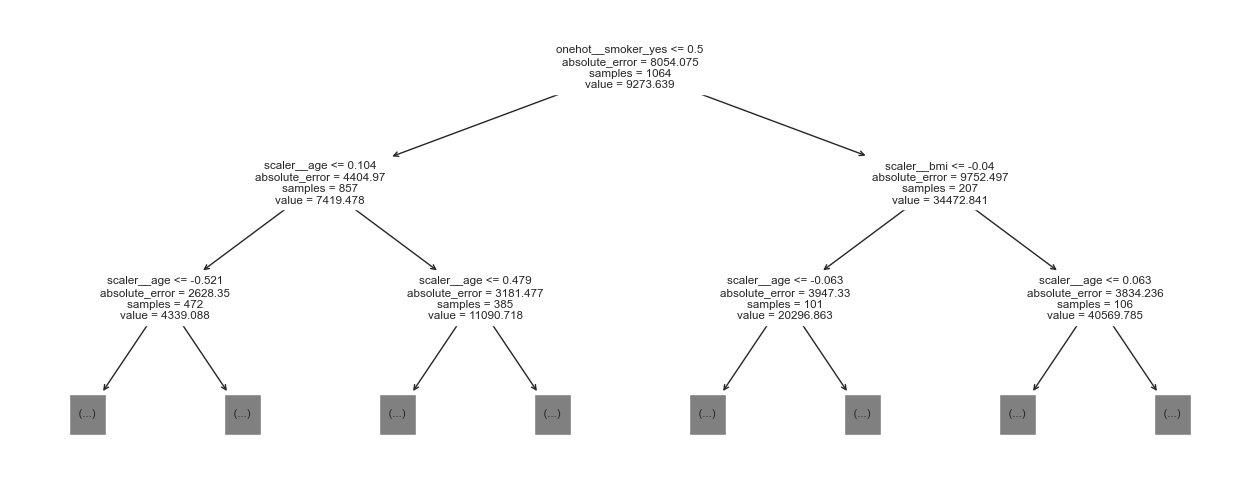

In [40]:
plt.figure(figsize=(16,6))
plot_tree(decision_tree=best_model['model'], max_depth=2, feature_names=transformer.get_feature_names_out());

In [41]:
best_model['model'].feature_importances_

array([3.80239867e-01, 1.85956908e-01, 2.49459075e-02, 3.35092716e-03,
       4.03808036e-01, 0.00000000e+00, 1.50803018e-04, 1.54755036e-03])

In [42]:
feature_importance = pd.DataFrame({
    'feature': transformer.get_feature_names_out(),
    'importance': best_model['model'].feature_importances_
}).sort_values('importance', ascending=False)

feature_importance

,feature,importance
4,onehot__smoker_yes,0.403808
0,scaler__age,0.380240
1,scaler__bmi,0.185957
2,scaler__children,0.024946
3,onehot__sex_male,0.003351
7,onehot__region_southwest,0.001548
6,onehot__region_southeast,0.000151
5,onehot__region_northwest,0.000000


<Axes: xlabel='importance', ylabel='feature'>

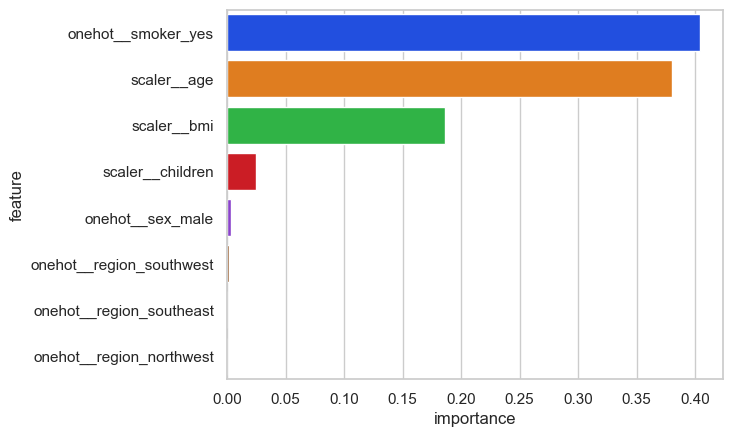

In [43]:
import seaborn as sns

sns.barplot(data=feature_importance, x='importance', y='feature')

In [44]:
import streamlit

streamlit.__version__

'1.22.0'

In [1]:
import pickle 
print(pickle.format_version)

4.0
